# Assignment 12
Our goal is to see if we can use an autoencoder to remove noise.
1. Copy the add_noise.ipynb code and the network part of the ae_emnist_simple.ipynb (the fully connected not the CNN) code to this workbook.
2. Train the autoencoder just as in class, and after training, send the **noisy** test digits through the autoencoder.  Does the autoencoder reconstruct them properly?  (**NOTE**: you could just load the pretrained model that we previously saved, rather than defining/compiling/fitting the model all over from scratch.)
    * Look at the **mse** for the **noisy** decoded images relative to the non-noisy version of the nopisy images you sent through the network.  Meaning: send the x_test_noisy images through the network and get the decoded images from these.  Then when making the mse, use the decoded images and the **non-noisy** version of the images to compare.   Remember that the goal of denoising is to remove the noise - so the decoded image should look like the non-noisy version of the original image!
    * Do the "eye-test" for 10 samples from the noisy dataset.
3. Now do the following: modify the **fit** part of the autoencoder:
    * Use the **noisy** training data x_train_noisy as your **input**
    * Use the **original** training data x_train as your **target**
    
    Train this new autoencoder.   Again, after training, send the **noisy** test digits through the autoencoder.  Does the autoencoder reconstruct them properly?
    * Again look at the **mse** for the **noisy** decoded images relative to the non-noisy version of the nopisy images you sent through the network.  Is this better than step 2?  It should be!
    * Do the "eye-test" for 10 samples from the noisy dataset.
    
**Extra**: Create another **stacked** autoencoder/classifier.   In this case, train on the letters dataset, but apply it to the digits just as in cnn_stacked_ae.   You will simply need to copy and modify the ae_cnn_emnist.py file so that it uses the letters (df_test['label']>9).  Save the new models with an "_letter" tag so that you don't overwrite the models trained using the digits.

**Load the EMNIST data and add noise.**

Using TensorFlow backend.


The y_train_labels_cat: (345035, 10)


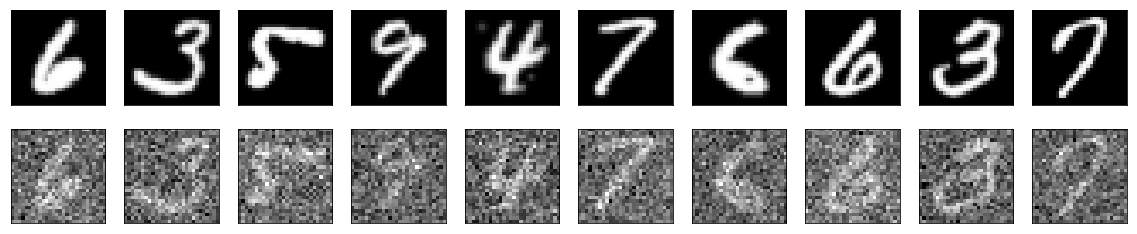

In [1]:
import numpy as np
import scipy.io as sio
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras import regularizers
#
# See this for more info: https://arxiv.org/pdf/1702.05373.pdf
mat = sio.loadmat('/fs/scratch/PAS1495/physics6820/emnist/matlab/emnist-byclass.mat')
#print(mat)

data = mat['dataset']

ex_train = data['train'][0,0]['images'][0,0]
ey_train = data['train'][0,0]['labels'][0,0]
ex_test = data['test'][0,0]['images'][0,0]
ey_test = data['test'][0,0]['labels'][0,0]

ex_train = ex_train.reshape( (ex_train.shape[0], 28,28), order='F')
ex_test = ex_test.reshape( (ex_test.shape[0], 28,28), order='F')

ex_train = ex_train.reshape( (ex_train.shape[0], 784))
ex_test = ex_test.reshape( (ex_test.shape[0], 784))
ex_train = ex_train.astype('float32') / 255.
ex_test = ex_test.astype('float32') / 255.

import pandas as pd

df_train = pd.DataFrame(ex_train)
df_train['label'] = ey_train

df_test = pd.DataFrame(ex_test)
df_test['label'] = ey_test

#
# Select digits, not letters.
df_digits_train = df_train[df_train['label']<=9]

x_train = df_digits_train.iloc[:,:784].values
y_train = df_digits_train['label'].values

df_digits_test = df_test[df_test['label']<=9]

x_test = df_digits_test.iloc[:,:784].values
y_test = df_digits_test['label'].values

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

#Convert the labels to one-hot encoded vectors
y_train_labels_cat = to_categorical(y_train)
y_test_labels_cat = to_categorical(y_test)

print("The y_train_labels_cat:", y_train_labels_cat.shape)

%matplotlib inline
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_train_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Train a fully connected autoencoder

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 784)               101136    
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________
network:  None
Train on 345035 samples, validate on 57918 samples
Epoch 1/25
345035/345035 [==============================] - 14s 40us/step - loss: 0.2773 - mean_squared_error: 0.0551 - val_loss: 0.2131 - val_mean_squared_error: 0.0325
Epoch 2/25
345035/345035 [==============================] - 14s 40us/step - loss: 0.1924 - mean_squared_error: 0.0259 - val_loss: 0.1774 - val_mean_squared_error: 0.0211
Epoch 3/25
345035/345035 [==============================] - 14s 40us/step - loss: 0.1679 - mean_squared_error: 0.0181 - val_lo

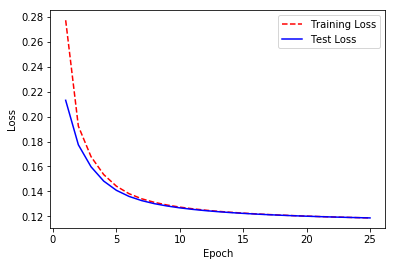

In [2]:


# this is the size of our encoded representations
encoding_dim = 128  
#
# Define out model
network = models.Sequential()
#
# This is the "encoder"
network.add(layers.Dense(encoding_dim,activation='relu',input_shape=(28*28,)))
#
# This is the decoder
network.add(layers.Dense(28*28,activation='sigmoid'))
#
# Now compile the network!
network.compile(optimizer='adadelta',loss='binary_crossentropy',metrics=['mse'])
print("network: ",network.summary())

history = network.fit(x_train, x_train,
                epochs=25,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

#print(history.history)
network.save('ae_fcn_'+str(encoding_dim)+'.h5')  # "tag" the file with the number of dimensions

%matplotlib inline
import matplotlib.pyplot as plt

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

decoded_imgs.shape (57918, 784)


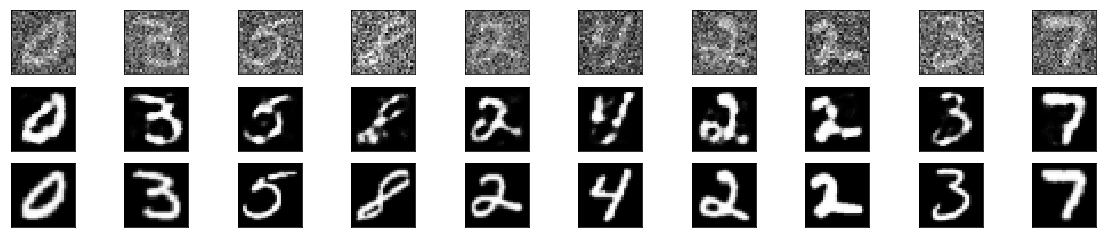

In [3]:
#Now feed it the images with noise and see if de-noised images are returned.
decoded_imgs = network.predict(x_test_noisy)
print("decoded_imgs.shape",decoded_imgs.shape)

%matplotlib inline
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display images with noise
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    #Display images after reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

The bottom row is the original images, the top is after addition of noise, and the middle row is the reconstruction images. Looks like a decent job has been done to remove the noise.

/apps/python/3.6-conda5.2/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


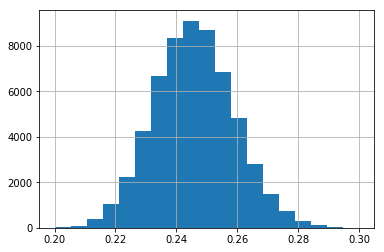

In [4]:
import pandas as pd

mse = np.mean(np.power(x_test_noisy-decoded_imgs, 2), axis=1)
df_digits_test['mse'] = mse

hist = df_digits_test['mse'].hist(bins=np.linspace(0.2,0.3,20))

**Now modify the fitting method by using noisy images as input and clean images as target. Since the ultimate goal is to train the autoencoder to reconstruct the images as clean as it should be.**

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 784)               101136    
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________
network:  None
Train on 345035 samples, validate on 57918 samples
Epoch 1/25
345035/345035 [==============================] - 14s 41us/step - loss: 0.1650 - mean_squared_error: 0.0168 - val_loss: 0.1609 - val_mean_squared_error: 0.0159
Epoch 2/25
345035/345035 [==============================] - 14s 41us/step - loss: 0.1584 - mean_squared_error: 0.0154 - val_loss: 0.1570 - val_mean_squared_error: 0.0150
Epoch 3/25
345035/345035 [==============================] - 14s 41us/step - loss: 0.1557 - mean_squared_error: 0.0147 - val_lo

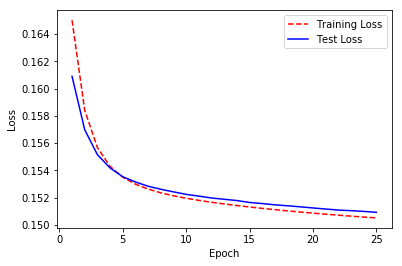

In [5]:
new_network = models.Sequential()
#
# This is the "encoder"
new_network.add(layers.Dense(encoding_dim,activation='relu',input_shape=(28*28,)))
#
# This is the decoder
new_network.add(layers.Dense(28*28,activation='sigmoid'))
#
# Now compile the network!
new_network.compile(optimizer='adadelta',loss='binary_crossentropy',metrics=['mse'])
print("network: ",new_network.summary())

new_history = network.fit(x_train_noisy, x_train,
                epochs=25,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

#print(history.history)
new_network.save('new_ae_fcn_'+str(encoding_dim)+'.h5')  # "tag" the file with the number of dimensions

%matplotlib inline
import matplotlib.pyplot as plt

# Get training and test loss histories
training_loss = new_history.history['loss']
test_loss = new_history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

decoded_imgs.shape (57918, 784)


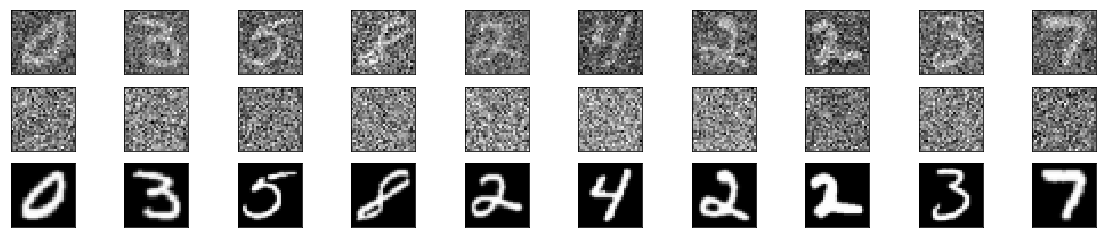

In [6]:
#Now feed it the images with noise and see if de-noised images are returned.
new_decoded_imgs = new_network.predict(x_test_noisy)
print("decoded_imgs.shape",decoded_imgs.shape)

%matplotlib inline
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display images with noise
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    #Display images after reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(new_decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

/apps/python/3.6-conda5.2/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


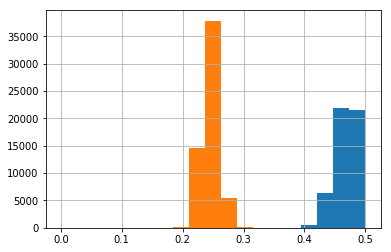

In [7]:
new_mse = np.mean(np.power(x_test_noisy-new_decoded_imgs, 2), axis=1)
df_digits_test['new_mse'] = new_mse

hist1 = df_digits_test['new_mse'].hist(bins=np.linspace(0,0.5,20))
hist2 = df_digits_test['mse'].hist(bins=np.linspace(0,0.5,20))

**Train a stacked autoencoder/classifier on letters, but apply it to the digits**

In [8]:
print(x_train.shape)

(345035, 784)


In [9]:
df_letters_train = df_train[df_train['label']>9]
x_train_letter = df_letters_train.iloc[:,:784].values
y_train_letter = df_letters_train['label'].values
df_letters_test = df_test[df_test['label']>9]
x_test_letter = df_letters_test.iloc[:,:784].values
y_test_letter = df_letters_test['label'].values
x_train_letter_noisy = x_train_letter + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_letter.shape) 
x_test_letter_noisy = x_test_letter + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_letter.shape)

x_train_letter = x_train_letter.reshape(-1, 28, 28, 1)
x_test_letter = x_test_letter.reshape(-1, 28, 28, 1)
x_train_letter_noisy = x_train_letter_noisy.reshape(-1, 28, 28, 1)
x_test_letter_noisy = x_test_letter_noisy.reshape(-1, 28, 28, 1)
y_train_letter_labels_cat = to_categorical(y_train_letter)
y_test_letter_labels_cat = to_categorical(y_test_letter)

print("x_train_letter", x_train_letter.shape)
print("x_test_letter.shape", x_test_letter.shape)
print("y_train_letter_labels_cat", y_train_letter_labels_cat.shape)
print("y_test_letter_labels_cat", y_test_letter_labels_cat.shape)

x_train_letter (352897, 28, 28, 1)
x_test_letter.shape (58405, 28, 28, 1)
y_train_letter_labels_cat (352897, 62)
y_test_letter_labels_cat (58405, 62)


In [10]:
# make our encoder
encoder = models.Sequential()
#
# First convolutional layer
encoder.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same',input_shape=(28,28,1)))
encoder.add(layers.MaxPooling2D((2,2), padding='same'))
encoder.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
encoder.add(layers.MaxPooling2D((2,2), padding='same'))
encoder.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
encoder.add(layers.MaxPooling2D((2,2), padding='same'))
print("encoder===>")
print(encoder.summary())

#
# Now make the decoder
# make our encoder
decoder = models.Sequential()
#
# First convolutional layer
decoder.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same',input_shape=(4,4,8)))
decoder.add(layers.UpSampling2D((2,2)))
decoder.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
decoder.add(layers.UpSampling2D((2,2)))
decoder.add(layers.Conv2D(16, (3, 3), activation='relu'))
decoder.add(layers.UpSampling2D((2,2)))
decoder.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
print("decoder===>")
print(decoder.summary())

ae = models.Sequential()
ae.add(encoder)
ae.add(decoder)
ae.compile(optimizer='adadelta', loss='binary_crossentropy',metrics=['mse'])
print("autoencoder===>")
print(ae.summary())

history = ae.fit(x_train_letter, x_train_letter,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_letter, x_test_letter))

encoder===>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
Total params: 1,904
Trainable params: 1,904
Non-trainable params: 0
______________________________________________________________

In [24]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
x_train_noisy = x_train_noisy.reshape(-1, 28, 28, 1)
x_test_noisy = x_test_noisy.reshape(-1, 28, 28, 1)
#Make the encoder layers untrainable
for layer in encoder.layers:
    layer.trainable = False
    print(layer, layer.trainable)
    
ae_stacked = models.Sequential()
ae_stacked.add(encoder)
ae_stacked.add(layers.Flatten())
ae_stacked.add(layers.Dense(64, activation='relu'))
ae_stacked.add(layers.Dense(10, activation='softmax'))

ae_stacked.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
history = ae_stacked.fit(x_train_noisy,y_train_labels_cat,epochs=5,batch_size=256,
                              validation_data=(x_test_noisy,y_test_labels_cat))
print(ae_stacked.summary())

ae_stacked.save('fully_trained_model_cnn_stacked_ae_letter.h5')

<keras.layers.convolutional.Conv2D object at 0x2accea00ad68> False
<keras.layers.pooling.MaxPooling2D object at 0x2accea00ae80> False
<keras.layers.convolutional.Conv2D object at 0x2accea03b438> False
<keras.layers.pooling.MaxPooling2D object at 0x2accea03b5f8> False
<keras.layers.convolutional.Conv2D object at 0x2acaf883db70> False
<keras.layers.pooling.MaxPooling2D object at 0x2accabeb6320> False
Train on 345035 samples, validate on 57918 samples
Epoch 1/5
345035/345035 [==============================] - 27s 79us/step - loss: 0.9840 - acc: 0.6822 - val_loss: 0.7526 - val_acc: 0.7583
Epoch 2/5
345035/345035 [==============================] - 27s 79us/step - loss: 0.6840 - acc: 0.7769 - val_loss: 0.7279 - val_acc: 0.7508
Epoch 3/5
345035/345035 [==============================] - 27s 79us/step - loss: 0.6279 - acc: 0.7937 - val_loss: 0.5767 - val_acc: 0.8103
Epoch 4/5
345035/345035 [==============================] - 27s 79us/step - loss: 0.5976 - acc: 0.8044 - val_loss: 0.5741 - val_acc

In [25]:
#Now feed it the images with noise and see if de-noised images are returned.
x_test_noisy = x_test_noisy.reshape(-1, 28, 28, 1)
print("noisy images evaluation", ae_stacked.evaluate(x_test_noisy, y_test_labels_cat))
print("clean images evaluation", ae_stacked.evaluate(x_test, y_test_labels_cat))

57918/57918 [==============================] - 6s 98us/step
noisy images evaluation [0.5565157578631929, 0.8179667806147031]
57918/57918 [==============================] - 6s 98us/step
clean images evaluation [0.8586498102519702, 0.7269933353969951]


The stacked network has "decent" accuracy on both of the noisy and clean images, when the network is trained on noisy images.

In [26]:
history = ae_stacked.fit(x_train,y_train_labels_cat,epochs=5,batch_size=256,
                              validation_data=(x_test,y_test_labels_cat))
print(ae_stacked.summary())

ae_stacked.save('fully_trained_model_cnn_stacked_ae_letter.h5')

#Now feed it the images with noise and see if de-noised images are returned.
x_test_noisy = x_test_noisy.reshape(-1, 28, 28, 1)
print("noisy images evaluation", ae_stacked.evaluate(x_test_noisy, y_test_labels_cat))
print("clean images evaluation", ae_stacked.evaluate(x_test, y_test_labels_cat))

Train on 345035 samples, validate on 57918 samples
Epoch 1/5
345035/345035 [==============================] - 27s 77us/step - loss: 0.1829 - acc: 0.9457 - val_loss: 0.1415 - val_acc: 0.9578
Epoch 2/5
345035/345035 [==============================] - 27s 78us/step - loss: 0.1240 - acc: 0.9626 - val_loss: 0.1081 - val_acc: 0.9676
Epoch 3/5
345035/345035 [==============================] - 27s 78us/step - loss: 0.1030 - acc: 0.9689 - val_loss: 0.0980 - val_acc: 0.9696
Epoch 4/5
345035/345035 [==============================] - 27s 78us/step - loss: 0.0906 - acc: 0.9725 - val_loss: 0.0937 - val_acc: 0.9711
Epoch 5/5
345035/345035 [==============================] - 27s 77us/step - loss: 0.0828 - acc: 0.9748 - val_loss: 0.0826 - val_acc: 0.9744
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 4, 4, 8)           1904      
________________________________________________________

When the network is trained on the clean images, the accuracy on the noisy images is very poor, but the accuracy on the clean images is very good.